
# Alphabet (GOOGL) — Prices, STL Decomposition, Log Returns, and WSS Diagnostics

In this notebook, we analyze **real financial data** from Yahoo Finance. This notebook follows a practical workflow:
1) **Download** daily prices for Alphabet (Google) — ticker `GOOGL` — via `yfinance`.
2) Run ADF, KPSS, ARCH LM tests on prices.
3) Use STL to extract trend, seasonality, residuals; plot components.
4) Run ADF, KPSS, ARCH LM on residuals.
5) Compute log returns and re-test.


## Imports and helper functions

Before working with the data, we need to import several Python libraries:

- **Core libraries**
  - `numpy` and `pandas` for numerical computations and data handling.
  - `matplotlib.pyplot` for plotting time series and results.

- **Time series analysis (from statsmodels)**
  - `STL` for Seasonal–Trend decomposition using Loess (to separate trend, seasonality, and residuals).
  - `adfuller` for the **ADF test** (Augmented Dickey–Fuller) — checks for nonstationarity in the mean.
  - `kpss` for the **KPSS test** — checks whether a series is stationary around a level.
  - `het_arch` for the **ARCH LM test** — detects conditional heteroskedasticity (time-varying volatility).

In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.filterwarnings("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "figure.dpi": 120,
    "axes.grid": True
})

def show_series(y, title="", xlabel="t", ylabel="Y_t", fontsize=14):
    fig, ax = plt.subplots()
    ax.plot(y, lw=1.2)
    if title:
        ax.set_title(f"{title}", fontsize=fontsize)
    if xlabel:
        ax.set_xlabel(f"${xlabel}$", fontsize=fontsize)
    if ylabel:
        ax.set_ylabel(f"${ylabel}$", fontsize=fontsize)
    ax.tick_params(axis="both", which="major", labelsize=fontsize-2)
    plt.tight_layout()
    plt.show()

# ADF, KPSS(level), ARCH LM tests with brief interpretations
def summary_tests(y, alpha=0.05, name="Series"):
    y = pd.Series(y).dropna().values
    print(f"=== Tests for {name} ===")
    # ADF
    try:
        adf_stat, adf_p, *_ = adfuller(y, autolag="AIC")
        print(f"ADF: stat={adf_stat:.3f}, p={adf_p:.3g}")
        print(" -> Reject nonstationarity (mean more likely stationary)" if adf_p < alpha
              else " -> Fail to reject nonstationarity (trend/nonstationary mean likely)")
    except Exception as e:
        print(f"ADF error: {e}")
    # KPSS
    try:
        kpss_stat, kpss_p, *_ = kpss(y, regression="c", nlags="auto")
        print(f"KPSS(level): stat={kpss_stat:.3f}, p={kpss_p:.3g}")
        print(" -> Reject stationarity around a level (nonstationary mean)" if kpss_p < alpha
              else " -> Fail to reject stationarity around a level (mean plausibly constant)")
    except Exception as e:
        print(f"KPSS error: {e}")
    # ARCH LM
    try:
        arch_stat, arch_p, *_ = het_arch(y)
        print(f"ARCH LM: stat={arch_stat:.3f}, p={arch_p:.3g}")
        print(" -> Reject homoskedasticity (time-varying volatility)" if arch_p < alpha
              else " -> Fail to reject homoskedasticity (variance appears stable)")
    except Exception as e:
        print(f"ARCH LM error: {e}")
    print()


## 1) Download and plot daily prices

The first step is to obtain the raw data we want to analyze.

- We use the `yfinance` library to download **daily adjusted close prices** for Alphabet (Google) under the ticker `GOOGL`.
  - *Adjusted close* accounts for stock splits and dividends, so it reflects the true economic value of holding the stock.
  - If internet access is unavailable, we generate a **synthetic random walk** as a fallback so the workflow can still run.

- Once we have the price series:
  - We **print the data source** (real Yahoo Finance vs. synthetic fallback).
  - We **plot the daily prices** so students can clearly see the strong **trend** typical of financial prices.

**Why plot first?**
- Visual inspection is a simple but important diagnostic step:
  - If the series shows an upward or downward drift, this suggests **nonstationarity in the mean**.
  - Large swings or volatility bursts can indicate **heteroskedasticity**.

This plot will motivate why we need to apply transformations (like STL decomposition or log returns) and formal tests in the next steps.

Data source: synthetic fallback ('str' object is not callable)


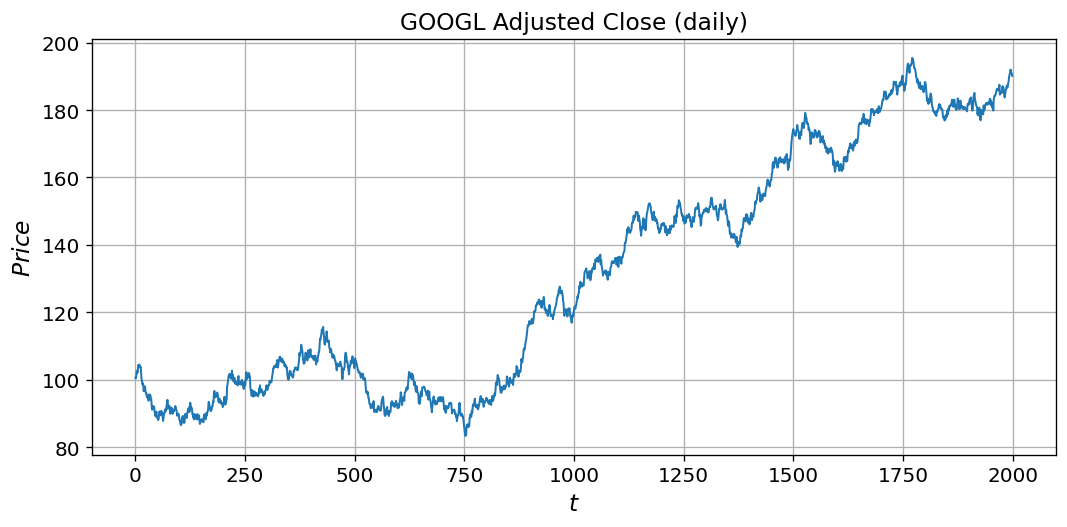

=== Tests for Prices ===
ADF: stat=0.188, p=0.972
 -> Fail to reject nonstationarity (trend/nonstationary mean likely)
KPSS(level): stat=6.512, p=0.01
 -> Reject stationarity around a level (nonstationary mean)
ARCH LM: stat=1988.424, p=0
 -> Reject homoskedasticity (time-varying volatility)



In [5]:
try:
    import yfinance as yf
    start = "2015-01-01"
    end = dt.date.today().isoformat()
    df = yf.download("GOOGL", start=start, end=end, auto_adjust=True, progress=False)
    prices = df["Close"].rename("GOOGL_Close")
    source = "yfinance"
    if prices.dropna().empty:
        raise RuntimeError("Empty series from yfinance.")
except Exception as e:
    np.random.seed(42)
    T = 2000
    prices = pd.Series(100 + np.cumsum(np.random.normal(0, 1, T)), name="GOOGL_Close")
    source = f"synthetic fallback ({e})"

print("Data source:", source)
show_series(prices, title="GOOGL Adjusted Close (daily)", xlabel="t", ylabel="Price")
summary_tests(prices, name="Prices")


## 2) STL decomposition and component plots

We now separate the series into **Trend**, **Seasonality**, and **Residuals** using
**STL** — Seasonal–Trend decomposition via Loess (local regression):

- **Additive model:**
  $$
  Y_t \;=\; T_t \;+\; S_t \;+\; R_t,
  $$
  where $T_t$ is a smooth **trend**, $S_t$ is a repeating **seasonal** pattern, and $R_t$ is the **residual** (noise).

- **Seasonal period (daily equities):**
  For daily stock data, an annual trading cycle is roughly **252 trading days**.
  We set `period=252` when there is enough data; otherwise, we fall back to a smaller period.

- **What to look for in the plots:**
  - **Trend $T_t$:** a smooth curve capturing long-run drift.
    If it slopes up/down, the original series had nonstationary mean.
  - **Seasonality $S_t$:** a repeating pattern with period ≈ 252.
    If it is small/flat, seasonality may be weak or absent.
  - **Residuals $R_t$:** what remains after removing $T_t$ and $S_t$.
    Ideally, $R_t$ should resemble “noise” with a roughly constant level and variance.

- **Next step:**
  We will **test the residuals** $R_t$ using ADF (mean stationarity), KPSS (level stationarity), and ARCH LM (variance stability).
  If $R_t$ passes these checks (or is closer to passing than raw prices), STL has effectively removed the nonstationary components that obstruct forecasting.

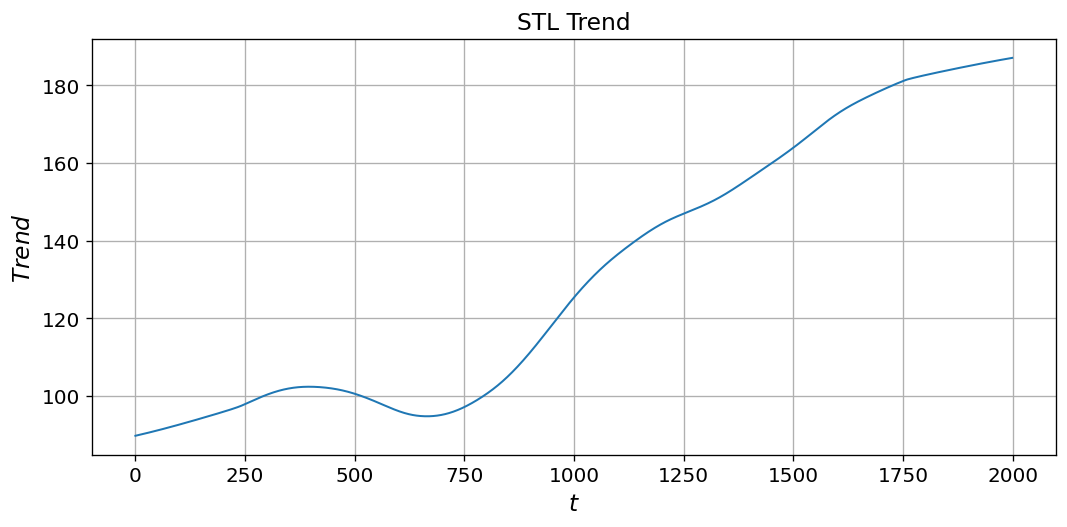

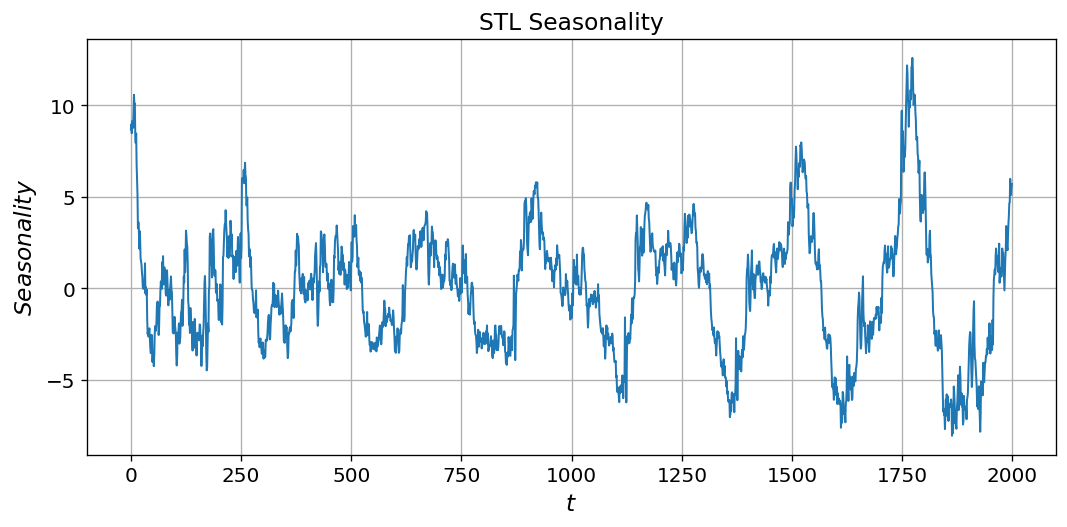

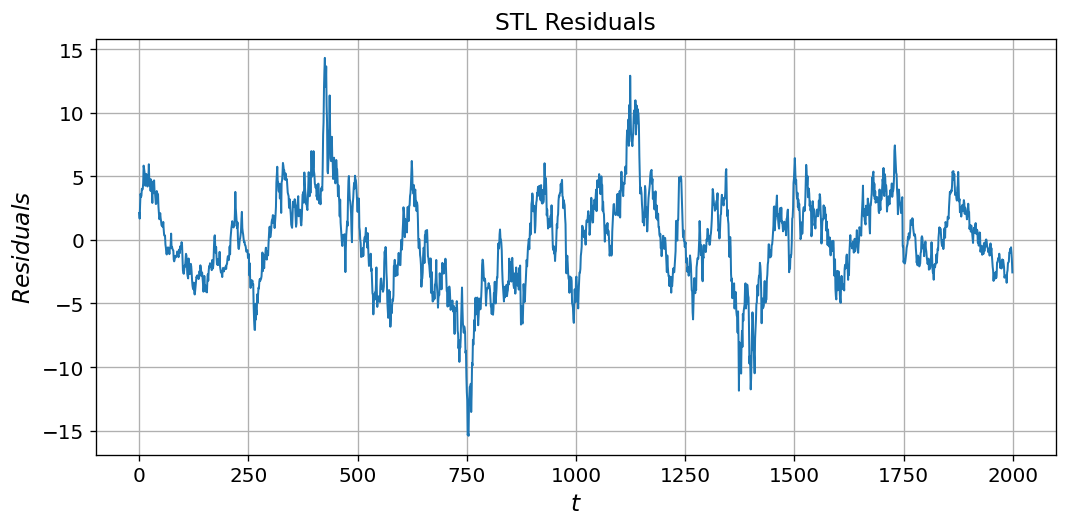

=== Tests for Residuals (STL) ===
ADF: stat=-4.850, p=4.36e-05
 -> Reject nonstationarity (mean more likely stationary)
KPSS(level): stat=0.152, p=0.1
 -> Fail to reject stationarity around a level (mean plausibly constant)
ARCH LM: stat=1700.707, p=0
 -> Reject homoskedasticity (time-varying volatility)



In [8]:
period = 252 if len(prices) >= 400 else 60
stl = STL(prices.dropna(), period=period, robust=True)
res_stl = stl.fit()

# STL component plot
trend = res_stl.trend.rename("Trend")
seasonal = res_stl.seasonal.rename("Seasonality")
resid = (prices - trend - seasonal).rename("Residuals").dropna()

show_series(trend, title="STL Trend", xlabel="t", ylabel="Trend")
show_series(seasonal, title="STL Seasonality", xlabel="t", ylabel="Seasonality")
show_series(resid, title="STL Residuals", xlabel="t", ylabel="Residuals")

summary_tests(resid, name="Residuals (STL)")


## 3) Log returns and tests

An alternative (and very common) transformation in finance is to move from **prices** to **returns**.

- **Why?**
  - Prices are almost always **nonstationary**: they grow (or fall) over time and exhibit trends.
  - Returns, defined as relative changes in price, often have a more stable mean and variance, which makes them closer to satisfying the **necessary conditions** for weak stationarity.

- **Log return definition:**
  Instead of simple percentage changes, we compute **logarithmic returns**:
  $$
  r_t \;=\; 100 \times \big( \log P_t - \log P_{t-1} \big),
  $$
  where $P_t$ is the price at time $t$.
  - The factor of $100$ expresses returns in **percentages**.
  - Using logs makes returns additive over time and often closer to Gaussian noise.

- **What we do next:**
  1. Compute log returns from the daily prices.
  2. Plot the return series to see its erratic but mean-reverting nature.
  3. Run the same three diagnostics — **ADF**, **KPSS**, and **ARCH LM** — to check whether the returns have a constant mean and variance, and whether volatility is stable.

- **Typical outcome in financial data:**
  - Returns usually pass **ADF/KPSS** (no trend in the mean).
  - However, **ARCH LM** often rejects homoskedasticity, showing **volatility clustering** (periods of calm vs. turbulence).
  - This motivates models like **GARCH** where the volatility is a dynamic variable.

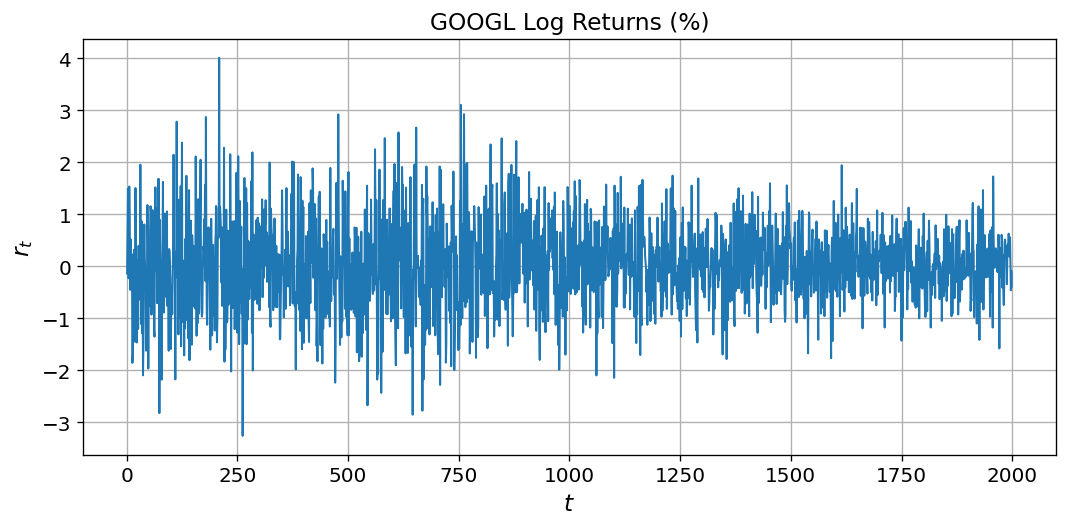

=== Tests for Log returns ===
ADF: stat=-45.474, p=0
 -> Reject nonstationarity (mean more likely stationary)
KPSS(level): stat=0.152, p=0.1
 -> Fail to reject stationarity around a level (mean plausibly constant)
ARCH LM: stat=67.378, p=1.42e-10
 -> Reject homoskedasticity (time-varying volatility)



In [10]:
log_prices = np.log(prices)
returns = 100 * log_prices.diff().dropna()
returns.name = "LogReturn(%)"

show_series(returns, title="GOOGL Log Returns (%)", xlabel="t", ylabel="r_t")
summary_tests(returns, name="Log returns")



## 4) Takeaways

- **Prices** typically exhibit a nonstationary mean (trend) and sometimes time-varying variance.  
- **STL residuals** should be closer to satisfying the necessary conditions (mean/variance stability).  
- **Log returns** are a standard alternative that often pass mean-stationarity checks, though volatility clustering (ARCH) may remain.
